In [ ]:
import numpy as np
import cifar100 as cf
import matplotlib.pyplot as plt

In [ ]:
imgs, labels  = cf.load_data(cf.file_path+"train")
Xtest , Ytest = cf.load_data(cf.file_path+"test")

s = np.random.permutation(imgs.shape[0])           # randomly shuffle the images and their corresponding labels
imgs   = imgs[s]
labels = labels[s]

Xtr = imgs[:45000]                   # 90 % of the data is used for training
Ytr = labels[:45000]
Xval = imgs[45000:]                  # 10 % for validation
Yval = labels[45000:]

In [ ]:
mean_img = Xtr.mean()                    # Mean image of the training data

Xtr  = cf.zero_center(Xtr, mean_img)     # zero center validation and training data
Xval = cf.zero_center(Xval, mean_img)
Xtest = cf.zero_center(Xtest, mean_img)

Xtr  = cf.convert_images(Xtr)           # scale image values to range 0..1
Xval = cf.convert_images(Xval)
Xtest = cf.convert_images(Xtest)

In [31]:
class NeuralNetwork():
    
    def __init__(self,D,k,hidden_layers,nodes,activ=0):   # D input dimensionality , K output dimensionality
        self.activation_func = 0                           # RelU activation
        # Initialize Network Paramaters
        self.hidden_layers = hidden_layers     # Number of hidden layers
        self.nodes = nodes                     # list of number of nodes per layer
        self.k = k
        self.D = D
       
    def InitWeights(self):
        
        # Initialize Weights 
        self.Weights = np.empty(self.hidden_layers+1,dtype = object)                     # list of network weights
        # Xavier Initialization
        self.Weights[0]   = np.random.randn(self.D,self.nodes[0])* np.sqrt(2.0/ self.D)  # first layer Weights [D X l1_nodes]
        self.Weights[1:-1]= [np.random.randn(self.nodes[i-1],self.nodes[i]) * np.sqrt(2.0/self.nodes[i-1]) for i in range(1,self.hidden_layers)] 
        self.Weights[-1]  =  np.random.randn(self.nodes[self.hidden_layers-1] , self.k) * np.sqrt(2.0/self.nodes[self.hidden_layers-1])  
        
        # Initialize Bias
        self.b = np.empty(self.hidden_layers+1,dtype = object)           # list of network biases
        self.b[0:-1] = [np.zeros((1,self.nodes[i])) for i in range(self.hidden_layers)]   # [1 X li_nodes]
        self.b[-1] = np.zeros((1,self.k))                                            # [1 X output_nodes]
       
        # Initialize layers activations
        self.h = np.empty(self.hidden_layers, dtype=object)           # list of hidden layers activations
        self.out = np.zeros((self.k,1))                               # output scores [k X 1]
           
        self.mog = 0                         # Initialize momentum and accumalation values to zero
        self.ACCg = 0
        
        self.mob = 0
        self.ACCb = 0
        
    def forwardP(self,x , y):
 
        f = self.__activ_func()                            
        self.h[0] = f(np.dot(x, self.Weights[0])+ self.b[0])          # [1 X l0_nodes]
        self.h[1:] = [ f(np.dot(self.h[i-1], self.Weights[i])+ self.b[i]) for i in range(1,self.hidden_layers)]
        self.out = np.dot(self.h[-1], self.Weights[-1])+ self.b[-1] 
        return self.out
    
    def forwardPtest(self, x,y, Weights, b):
        f = self.__activ_func()                            
        self.h[0] = f(np.dot(x, Weights[0])+ b[0])          # [1 X l0_nodes]
        self.h[1:] = [ f(np.dot(self.h[i-1], Weights[i])+ b[i]) for i in range(1,self.hidden_layers)]
        self.out = np.dot(self.h[-1], Weights[-1])+ b[-1]      
        return self.out
    
    
    # Computes cross entropy loss
    def loss(self , output, correct_labels):
        num_points = output.shape[0]
        exp_scores = np.exp(output)            # apply softmax function
        probs = exp_scores/ np.sum(exp_scores, axis = 1, keepdims = True)
    
        NLL = -np.log(probs[range(num_points) ,correct_labels])   # negative log likelihood of the correct class probability
        data_loss = np.sum(NLL)/num_points
       
        # L2 Regularization
        Wsqr = self.Weights * self.Weights  
        wreg_loss = [np.sum(Wsqr[i]) for i in range(Wsqr.shape[0])]   # sum all the squared elements of W
        reg_loss  =  0.5*self.reg *np.sum(wreg_loss)                  # multiply by the regularization paramater
        
        return (reg_loss + data_loss) , probs
        
    def backwardP(self, probs,Xtr_batch, Ytr_batch):
        dw = np.empty(self.hidden_layers+1, dtype = object)              # partial derivative with respect to Weights 
        dh = np.empty(self.hidden_layers, dtype = object)                # error of hidden layr h
        db = np.empty(self.hidden_layers+1, dtype = object)              # partial derviative with respect to the bias
        
        num_points = self.out.shape[0]   
        
        dscores = probs                                          # output error delta of the last layer
        dscores[range(num_points), Ytr_batch] -= 1               # correct class probability - target(1)
        dscores = dscores / num_points                           # average the gradient of the batch
        
        db[-1] = np.sum(dscores, axis = 0, keepdims = True)      # Bias partial derivative  of the last hidden layer
        
        # backpropagate the gradient to the weights
        # last layer weights
        dw[-1] = np.dot(np.transpose(self.h[-1]), dscores)
        
        # backpropagate to the hidden layers
        dh[-1] = np.dot(dscores, np.transpose(self.Weights[-1]))
        df = self.__dactiv_func()
        dh[-1] = dh[-1] * df(self.h[-1])                            # element wise multiplication
        
        db[self.hidden_layers-1] = np.sum(dh[-1], axis=0, keepdims = True)
        
        for i in range(self.hidden_layers-2, -1, -1):
            dh[i] = np.dot(dh[i+1], np.transpose(self.Weights[i+1]))   # hidden error
            dh[i] = dh[i] * df(self.h[i])                          # hidden error multiplied by partial derivative of activation h
            db[i] = np.sum(dh[i], axis=0, keepdims= True)

        dw[0] = np.dot(np.transpose(Xtr_batch) ,dh[0])
                
        for i in range(1,self.hidden_layers):
            dw[i] = np.dot(np.transpose(self.h[i-1]), dh[i]) 
            
        # Then add regularization contribution to the deltas W
        for i in range(self.hidden_layers+1):
            dw[i] = dw[i] +  self.reg * self.Weights[i]
        
        return dw,db
       
        
    def minibatch(self,Xtr,Ytr, size):
        s = np.random.permutation(Xtr.shape[0])
        Xtr_shuffled = Xtr[s]
        Ytr_shuffled = Ytr[s]
        return Xtr_shuffled[:size,], Ytr_shuffled[:size,]
    
    def updateWeights(self,dw,db):
        # Parameter update Adam
        beta1 = 0.9
        beta2 = 0.99
        # Momentum update
        self.mog = self.mog* beta1 + (1-beta1) * dw
        self.ACCg= beta2 * self.ACCg+ (1-beta2) * dw * dw
        self.Weights +=  -self.alpha * self.mog/ ( (self.ACCg*0.5) + 1*10**(-7))
        
        self.mob = self.mob * beta1 + (1-beta1) * db
        self.ACCb = beta2 * self.ACCb + (1-beta2) * db * db
        self.b += -self.alpha * self.mob/ ( (self.ACCb * 0.5) + 1 * 10**(-7))
         
    def train(self, Xtr, Ytr, Xval, Yval , alpha , reg, num_epochs, activation_func, batch_size):
        
        self.InitWeights()                       # randomly initialize weights
        
        self.alpha = alpha                       # learning rate
        self.activation_func = activation_func   # activation function
        self.reg = reg                           # Regularization Parameter
        
        tr_acc  = []
        val_acc = []
        
        loss_hist = []
        loss_avg = []
        
        train_loss = []
        valid_loss = []
        
        m = len(Ytr)               # Number of training examples 
        Weights_hist = np.empty(num_epochs , dtype = object)
        bias_hist = np.empty(num_epochs, dtype = object)
        # gradient descent loop
        for i in range(num_epochs):
            s = np.random.permutation(Xtr.shape[0])
            Xtr_shuffled = Xtr[s]
            Ytr_shuffled = Ytr[s]
            
            loss = []
            train_accs = []
            for k in range(0,m,batch_size): 
                Xtr_batch = Xtr_shuffled[k: k + batch_size] 
                Ytr_batch = Ytr_shuffled[k: k + batch_size]   
            
                scores = self.forwardP(Xtr_batch, Ytr_batch)                   # forward propagate the training data
                batchloss , probs = self.loss(scores, Ytr_batch)               # calculate the cross entropy loss
                loss.append(batchloss)
                
                loss_hist.append(batchloss)
                
                dw, db = self.backwardP(probs,Xtr_batch, Ytr_batch)            # backpropagate to calculate partial derivative
                self.updateWeights(dw,db)                                      # update Weight paramters
                
                predicted_class = np.argmax(scores, axis = 1)                
                train_acc = np.mean(Ytr_batch == predicted_class)
                train_accs.append(train_acc)                
           
            #validation set accuracy
            val_scores  = self.forwardP(Xval, Yval)
            val_predicted_class = np.argmax(val_scores ,axis = 1 )
            valid_acc = np.mean(val_predicted_class == Yval)
            val_acc.append(valid_acc)
            validloss , probs = self.loss(val_scores, Yval)               # calculate the cross entropy loss
            valid_loss.append(validloss)
        
            
            avg_loss = np.mean(loss)            # average loss across all the batches
            train_loss.append(avg_loss)
            
            avg_train_acc = np.mean(train_accs)
            tr_acc.append(avg_train_acc)
            
            loss_avg.append(avg_loss)
            print("Epoch %d: loss %f , tr_acc %f , val_acc %f , lr %e, reg %e" %(i, avg_loss , avg_train_acc ,valid_acc, self.alpha, self.reg))
            
            Weights_hist[i] = self.Weights
            bias_hist[i] = self.b
                        
        return tr_acc, val_acc , loss_hist ,  train_loss,valid_loss,Weights_hist, bias_hist
    
    def __activ_func(self):
        switcher= {
             0 : lambda x: np.maximum(0,x),             # RelU 
             1 : lambda x: np.maximum(0.01*x, x),       # Leaky Relu
             2 : lambda x: np.tanh(x),                  # tanh
             3 : lambda x: 1.0/ (1+np.exp(-x))          # sigmoid
        }
        return(switcher.get(self.activation_func,"invalid"))
    
    def __dactiv_func(self):
        sigm = lambda x: 1.0/ (1+np.exp(-x))
        switcher= {
             0 : lambda x: self.__dReLU(x) ,
             1 : lambda x: self.__dleakyReLU(x),
             2 : lambda x: 1-tanh(x)**2,
             3 : lambda x: x*(1-x)
        }
        return(switcher.get(self.activation_func,"invalid"))
    
    def __dReLU(self,x):
        dx = np.ones(x.shape)
        dx[x<=0] = 0
        return dx
    
    def __dleakyReLU(self,x):
        x[x<=0.01*x] = 0.01
        x[x>0.01*x]  = 1
        
    def deadNeurons(self):
        count = 0
        for i in range(self.hidden_layers):
            count = count + (np.sum(self.h[i] == 0))
        return count

In [32]:
nn = NeuralNetwork(3072,20,2,[3072,100])              # Specify Network Archietecure 

In [ ]:
# Find Min and Max range of alpha
reg    = 0.0000000001                     # very small regularization
alpha_min = 10**(-11)                     # Loss barely changes
alpha_max = 10**(-5)                      # Loss explodes
train_acc , valid_acc, loss_hist, train_loss, valid_loss = nn.train(Xtr[:10000],Ytr[:10000], Xval[:1000], Yval[:1000],10**(-6),reg,10,0,256)   # alpha , reg , num_epochs , activ_func , batch_size
# alpha range [10**(-11), 10**(-5)]

In [40]:
# Optimize hyper-paramaters alpha and regularization paramater
# Coarse Search and fine search loap
# rough experimentation with different values for the paramaters using 10000 training examples
models  = np.zeros(100, dtype = float)
alphas  = np.zeros(100, dtype = float)
regs    = np.zeros(100, dtype = float)

for i in range(50):
    
    reg   = 10 ** np.random.uniform(-4,-5)               # search in the log scale
    alpha = 10 ** np.random.uniform(-7, -8)             # in the max and min rang of alpha
    
    train_acc , valid_acc,loss_hist,train_loss,valid_loss,w_hist,b_hist = nn.train(Xtr[:10000],Ytr[:10000], Xval[:1000], Yval[:1000],alpha,reg,4,0,256)   # alpha , reg , num_epochs , activ_func , batch_size
    max_valid =    max(valid_acc)         #max(valid_acc)
    
    models[i] = max_valid
    
    alphas[i] = alpha
    regs[i] = reg
    
    print("iteration %d:  val_acc %f , lr %e , reg %e" %(i,max_valid, alpha, reg))
    

Epoch 0: loss 2.879939 , tr_acc 0.170313 , val_acc 0.236000 , lr 3.391845e-08, reg 4.781215e-05
Epoch 1: loss 2.566074 , tr_acc 0.263672 , val_acc 0.273000 , lr 3.391845e-08, reg 4.781215e-05
Epoch 2: loss 2.420291 , tr_acc 0.313672 , val_acc 0.290000 , lr 3.391845e-08, reg 4.781215e-05
Epoch 3: loss 2.321932 , tr_acc 0.353906 , val_acc 0.291000 , lr 3.391845e-08, reg 4.781215e-05
iteration 0:  val_acc 0.291000 , lr 3.391845e-08 , reg 4.781215e-05
Epoch 0: loss 3.020739 , tr_acc 0.157129 , val_acc 0.234000 , lr 3.073974e-08, reg 8.002060e-05
Epoch 1: loss 2.699420 , tr_acc 0.263184 , val_acc 0.267000 , lr 3.073974e-08, reg 8.002060e-05
Epoch 2: loss 2.544784 , tr_acc 0.310742 , val_acc 0.268000 , lr 3.073974e-08, reg 8.002060e-05
Epoch 3: loss 2.440170 , tr_acc 0.346973 , val_acc 0.294000 , lr 3.073974e-08, reg 8.002060e-05
iteration 1:  val_acc 0.294000 , lr 3.073974e-08 , reg 8.002060e-05
Epoch 0: loss 2.814228 , tr_acc 0.166113 , val_acc 0.230000 , lr 2.850415e-08, reg 2.428137e-05


Epoch 1: loss 2.724411 , tr_acc 0.252832 , val_acc 0.261000 , lr 2.833860e-08, reg 8.359781e-05
Epoch 2: loss 2.576194 , tr_acc 0.299902 , val_acc 0.274000 , lr 2.833860e-08, reg 8.359781e-05
Epoch 3: loss 2.494371 , tr_acc 0.330762 , val_acc 0.284000 , lr 2.833860e-08, reg 8.359781e-05
iteration 18:  val_acc 0.284000 , lr 2.833860e-08 , reg 8.359781e-05
Epoch 0: loss 2.843329 , tr_acc 0.160645 , val_acc 0.254000 , lr 2.734027e-08, reg 3.377708e-05
Epoch 1: loss 2.537360 , tr_acc 0.256738 , val_acc 0.278000 , lr 2.734027e-08, reg 3.377708e-05
Epoch 2: loss 2.409580 , tr_acc 0.305469 , val_acc 0.299000 , lr 2.734027e-08, reg 3.377708e-05
Epoch 3: loss 2.317178 , tr_acc 0.332520 , val_acc 0.289000 , lr 2.734027e-08, reg 3.377708e-05
iteration 19:  val_acc 0.299000 , lr 2.734027e-08 , reg 3.377708e-05
Epoch 0: loss 2.935038 , tr_acc 0.178223 , val_acc 0.243000 , lr 3.951451e-08, reg 7.719837e-05
Epoch 1: loss 2.597143 , tr_acc 0.278711 , val_acc 0.265000 , lr 3.951451e-08, reg 7.719837e-0

Epoch 2: loss 2.260964 , tr_acc 0.332324 , val_acc 0.294000 , lr 3.877525e-08, reg 1.260642e-05
Epoch 3: loss 2.135785 , tr_acc 0.373828 , val_acc 0.303000 , lr 3.877525e-08, reg 1.260642e-05
iteration 36:  val_acc 0.303000 , lr 3.877525e-08 , reg 1.260642e-05
Epoch 0: loss 2.951917 , tr_acc 0.143262 , val_acc 0.193000 , lr 1.730898e-08, reg 4.554378e-05
Epoch 1: loss 2.668578 , tr_acc 0.227051 , val_acc 0.242000 , lr 1.730898e-08, reg 4.554378e-05
Epoch 2: loss 2.534577 , tr_acc 0.283398 , val_acc 0.255000 , lr 1.730898e-08, reg 4.554378e-05
Epoch 3: loss 2.450684 , tr_acc 0.306641 , val_acc 0.269000 , lr 1.730898e-08, reg 4.554378e-05
iteration 37:  val_acc 0.269000 , lr 1.730898e-08 , reg 4.554378e-05
Epoch 0: loss 2.793010 , tr_acc 0.158398 , val_acc 0.223000 , lr 3.124151e-08, reg 1.425493e-05
Epoch 1: loss 2.467298 , tr_acc 0.265430 , val_acc 0.275000 , lr 3.124151e-08, reg 1.425493e-05
Epoch 2: loss 2.333301 , tr_acc 0.308398 , val_acc 0.288000 , lr 3.124151e-08, reg 1.425493e-0

In [41]:
# find best models
best_model = np.argsort(models)[::-1]

for i in range(20):
    print(" model %d ,val_acc %f , lr %e, reg %e" %(i , models[best_model[i]] , alphas[best_model[i]] , regs[best_model[i]] ))

 model 0 ,val_acc 0.311000 , lr 6.595541e-08, reg 1.525928e-05
 model 1 ,val_acc 0.308000 , lr 7.042529e-08, reg 3.722513e-05
 model 2 ,val_acc 0.306000 , lr 2.815899e-08, reg 4.698130e-05
 model 3 ,val_acc 0.305000 , lr 8.091997e-08, reg 2.317445e-05
 model 4 ,val_acc 0.303000 , lr 3.877525e-08, reg 1.260642e-05
 model 5 ,val_acc 0.302000 , lr 2.247203e-08, reg 3.131090e-05
 model 6 ,val_acc 0.301000 , lr 4.364165e-08, reg 1.986461e-05
 model 7 ,val_acc 0.300000 , lr 4.869804e-08, reg 1.610047e-05
 model 8 ,val_acc 0.299000 , lr 8.821846e-08, reg 1.241882e-05
 model 9 ,val_acc 0.299000 , lr 2.734027e-08, reg 3.377708e-05
 model 10 ,val_acc 0.299000 , lr 4.476603e-08, reg 6.071565e-05
 model 11 ,val_acc 0.297000 , lr 3.951451e-08, reg 7.719837e-05
 model 12 ,val_acc 0.297000 , lr 3.684645e-08, reg 5.118153e-05
 model 13 ,val_acc 0.296000 , lr 5.962822e-08, reg 4.249909e-05
 model 14 ,val_acc 0.296000 , lr 3.384066e-08, reg 6.277181e-05
 model 15 ,val_acc 0.296000 , lr 1.878627e-08, reg

In [42]:
# Train with model 0

alpha = 6.595541 * (10**(-8))
reg   = 1.525928 * (10**(-5))

print(" reg %e" %(reg))
print(" reg %e" %(alpha))

train_acc,valid_acc,loss_hist,train_loss,valid_loss,weight_hist,b_hist= nn.train(Xtr,Ytr, Xval, Yval,alpha,reg,50,0,256)


 reg 1.525928e-05
 reg 6.595541e-08
Epoch 0: loss 2.485545 , tr_acc 0.259622 , val_acc 0.305200 , lr 6.595541e-08, reg 1.525928e-05
Epoch 1: loss 2.223644 , tr_acc 0.339492 , val_acc 0.327000 , lr 6.595541e-08, reg 1.525928e-05
Epoch 2: loss 2.105629 , tr_acc 0.378268 , val_acc 0.339600 , lr 6.595541e-08, reg 1.525928e-05
Epoch 3: loss 2.012175 , tr_acc 0.406109 , val_acc 0.352000 , lr 6.595541e-08, reg 1.525928e-05
Epoch 4: loss 1.934326 , tr_acc 0.432825 , val_acc 0.354000 , lr 6.595541e-08, reg 1.525928e-05
Epoch 5: loss 1.864929 , tr_acc 0.456034 , val_acc 0.364400 , lr 6.595541e-08, reg 1.525928e-05
Epoch 6: loss 1.798799 , tr_acc 0.478429 , val_acc 0.364000 , lr 6.595541e-08, reg 1.525928e-05
Epoch 7: loss 1.737576 , tr_acc 0.499978 , val_acc 0.362400 , lr 6.595541e-08, reg 1.525928e-05
Epoch 8: loss 1.681910 , tr_acc 0.519247 , val_acc 0.375000 , lr 6.595541e-08, reg 1.525928e-05
Epoch 9: loss 1.627809 , tr_acc 0.538975 , val_acc 0.379000 , lr 6.595541e-08, reg 1.525928e-05
Epoc

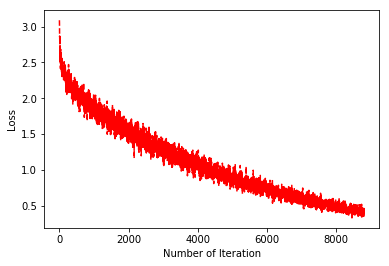

In [43]:
# Monitor loss versus number of epochs
plt.xlabel("Number of Iteration")
plt.ylabel("Loss")
x = np.arange(len(loss_hist))
plt.plot(x, loss_hist, 'r--')
plt.show()

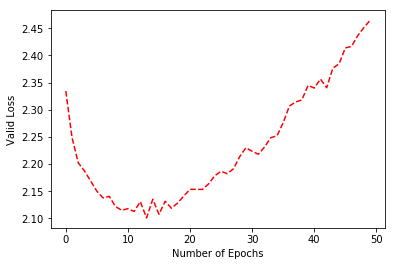

In [48]:
# Monitor loss versus number of epochs
plt.xlabel("Number of Epochs")
plt.ylabel("Valid Loss")
x = np.arange(len(valid_loss))
plt.plot(x, valid_loss, 'r--')
plt.show()

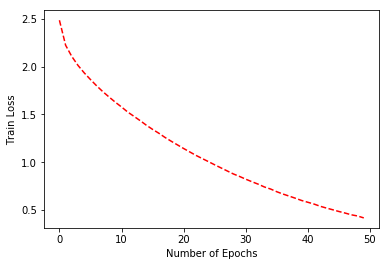

In [45]:
plt.xlabel("Number of Epochs")
plt.ylabel("Train Loss")
x = np.arange(len(train_loss))
plt.plot(x, train_loss, 'r--')
plt.show()

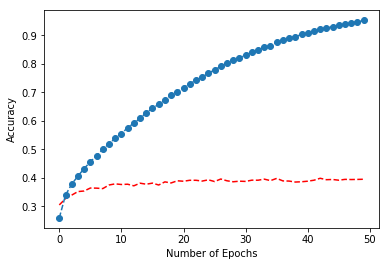

In [47]:
# Monitor valid accuracy versus training accuracy
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
x = np.arange(len(valid_acc))
plt.plot(x, valid_acc, 'r--')
plt.plot(x, train_acc, 'o--')
plt.show()

In [49]:
# apply testing test
scores = nn.forwardPtest(Xtest, Ytest,weight_hist[42], b_hist[42])     # test with the model with the heighest accuracy
predicted_class = np.argmax(scores, axis = 1)                
test_acc = np.mean(Ytest == predicted_class)
print("ACCR %f" %(test_acc))

ACCR 0.380700


In [50]:
# Correct classification rate
cc_rate = cf.ccrn(predicted_class , Ytest)
for i in range(len(cc_rate)):
    print("class %d ,ccrn %f" %(i ,cc_rate[i]))


[10 10  0 ...  4  8  2]
[10 12 15 ... 15 15 16]
class 0 ,ccrn 0.330000
class 1 ,ccrn 0.360000
class 2 ,ccrn 0.546000
class 3 ,ccrn 0.424000
class 4 ,ccrn 0.432000
class 5 ,ccrn 0.284000
class 6 ,ccrn 0.444000
class 7 ,ccrn 0.354000
class 8 ,ccrn 0.250000
class 9 ,ccrn 0.492000
class 10 ,ccrn 0.626000
class 11 ,ccrn 0.290000
class 12 ,ccrn 0.306000
class 13 ,ccrn 0.244000
class 14 ,ccrn 0.420000
class 15 ,ccrn 0.230000
class 16 ,ccrn 0.238000
class 17 ,ccrn 0.652000
class 18 ,ccrn 0.302000
class 19 ,ccrn 0.390000


In [ ]:
""" Trying to fine tune regularization paramater to overcome overfitting , but all the models gave relatively the same validation accuracy """
nn2 = NeuralNetwork(3072,20,2,[3072,100])              # Specify Network Archietecure 
reg   = 4.635987 * (10**(-5))
alpha = 3.268817 * (10**(-4))

regs = [13.8*10**(-5) , 41.4*10**(-5) , 24.2*10**(-5)]   # increase regularization paramater by a factor of 3

for i in range(len(regs)):
    train_acc2 , valid_acc2 ,loss_hist2 ,train_loss2,valid_loss2,w_hist2,b_hist2 = nn2.train(Xtr,Ytr, Xval, Yval,alpha,regs[i],25,0,256)
    plt.figure(i)
    plt.xlabel("Number of Epochs") 
    plt.ylabel("Accuracy")
    x = np.arange(len(valid_acc2))
    plt.plot(x, valid_acc2, 'r--')
    plt.plot(x, train_acc2, 'o--')
    plt.show()      